In [1]:
%load_ext autoreload
%autoreload 2
import datetime
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import casadi as cas

##### For viewing the videos in Jupyter Notebook
import io
import base64
from IPython.display import HTML

# from ..</src> import car_plotting
# from .import src.car_plotting
PROJECT_PATH = '/home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/'
sys.path.append(PROJECT_PATH)
import src.MPC_Casadi as mpc
import src.car_plotting as cplot
np.set_printoptions(precision=2)
%matplotlib inline

In [2]:
T = 10 #numbr of time horizons
dt = 0.1
N = int(T/dt) #Number of control intervals

In [3]:
s = cas.MX.sym('s')
xd = s
yd = 0
phid = 0
des_traj = cas.vertcat(xd, yd, phid)
fd = cas.Function('fd',[s],[des_traj],['s'],['des_traj'])

In [4]:
#Globally true information
min_dist = 2 * (2 * .5**2)**.5

# initial_speed = 6.7 
initial_speed = 20 * 0.447 # m/s

# Initial Conditions
x0 = np.array([2*min_dist, 1.2*min_dist, 0, 0, initial_speed, 0]).T
x0_2 = np.array([2*min_dist, 0, .0, 0, initial_speed, 0]).T
x0_amb = np.array([0, 0.0, 0, 0, 1.1 * initial_speed , 0]).T

In [5]:
LANE_WIDTH = min_dist
xd2 = s
yd2 = LANE_WIDTH
phid = 0
des_traj2 = cas.vertcat(xd2, yd2, phid)
fd2 = cas.Function('fd',[s],[des_traj2],['s'],['des_traj2'])

## IBR from Beginning

In [6]:
x1_MPC = mpc.MPC(dt)
x2_MPC = mpc.MPC(dt)
amb_MPC = mpc.MPC(dt)

x1_MPC.theta_iamb = 0
x2_MPC.theta_iamb =  0
amb_MPC.theta_iamb = 0


x1_MPC.k_final = 1.0
x2_MPC.k_final = 1.0
amb_MPC.k_final = 1.0


x1_MPC.k_s = -1.0
x2_MPC.k_s = -1.0

amb_MPC.theta_iamb = 0.0
amb_MPC.k_u_v = 0.10
# amb_MPC.k_u_change = 1.0
amb_MPC.k_s = -1.0
amb_MPC.max_v = 40 * 0.447 # m/s
amb_MPC.max_X_dev = 5.0


x2_MPC.fd = fd
amb_MPC.fd = fd
x1_MPC.fd = fd2


x1_MPC.min_y = -1.1 * LANE_WIDTH
x2_MPC.min_y = -1.1 * LANE_WIDTH
amb_MPC.min_y = -1.1 * LANE_WIDTH

In [8]:
ibr_sub_it = 1

In [9]:
optional_suffix = "_ibr_egoistic_50rds"
subdir_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + optional_suffix
folder = "results/" + subdir_name + "/"
os.makedirs(folder)
os.makedirs(folder+"imgs/")
print(folder)

results/20200220-223137_ibr_egoistic_50rds/


In [10]:
u1 = np.zeros((2,N))
u2 = np.zeros((2,N))

In [12]:
ibr_sub_it = 1
n_total_round = 50
for n_round in range(n_total_round):
    brA = mpc.IterativeBestResponseMPC(amb_MPC, x1_MPC, x2_MPC)
    brA.generate_optimization(N, min_dist, fd, T, x0_amb, x0, x0_2,  2, slack=True)
    brA.solve(u1, u2)
    print(brA.solution.value(brA.slack_cost))    
    print("A", brA.solution.value(brA.car1MPC.total_cost()))
    xamb, uamb, xamb_des, x1, u1, x1_des, x2, u2, x2_des = brA.get_solution()
    brA.save_state(folder + '%03d'%ibr_sub_it + "_a", x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des)
    ibr_sub_it+=1

    br2 = mpc.IterativeBestResponseMPC(x2_MPC, x1_MPC, amb_MPC )
    br2.generate_optimization(N, min_dist, fd, T, x0_2, x0, x0_amb, 2, slack=True)
    br2.solve(u1, uamb)
    x2, u2, x2_des, x1, u1, x1_des, xamb, uamb, xamb_des = br2.get_solution()
    print(br2.solution.value(br2.slack_cost))
    print("2", br2.solution.value(br2.car1MPC.total_cost()))
    br2.save_state(folder + '%03d'%ibr_sub_it + "_2", x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des)
    ibr_sub_it+=1

    br1 = mpc.IterativeBestResponseMPC(x1_MPC, x2_MPC, amb_MPC)
    br1.generate_optimization(N, min_dist, fd, T,  x0, x0_2, x0_amb, 2, slack=True)
    br1.solve(u2, uamb)
    x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des = br1.get_solution()
    print(br1.solution.value(br1.slack_cost))
    print("1", br1.solution.value(br1.car1MPC.total_cost()))
    br1.save_state(folder + '%03d'%ibr_sub_it + "_1", x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des)
    ibr_sub_it+=1

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  41.67ms (138.90us)  41.61ms (138.70us)       300
       nlp_g  | 341.10ms (  1.14ms) 340.13ms (  1.13ms)       300
    nlp_grad  |   3.98ms (  3.98ms)   3.96ms (  3.96ms)         1
  nlp_grad_f  |  86.26ms (286.59us)  86.32ms (286.79us)       301
  nlp_hess_l  |   4.16 s ( 13.92ms)   4.15 s ( 13.88ms)       299
   nlp_jac_g  |   2.48 s (  8.22ms)   2.47 s (  8.19ms)       301
       total  |   9.98 s (  9.98 s)   9.94 s (  9.94 s)         1
3.5519878141912654e-10
A -11449.49650059501
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 191.07ms (121.39us) 190.46ms (121.01us)      1574
       nlp_g  |   1.81 s (  1.15ms)   1.81 s (  1.15ms)      1574
    nlp_grad  |   4.28ms (  4.28ms)   4.26ms (  4.26ms)         1
  nlp_grad_f  | 387.00ms (273.88us) 386.36ms (273.43us)      1413
  nlp_hess_l  |  21.94 s ( 14.14ms)  21.86 s ( 14.09ms)      1552
   nlp_jac_g  |  12.96 s (  8.32

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:159:
.../casadi/core/optistack_internal.cpp:999: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Maximum_Iterations_Exceeded'

## Why is agent one doing weird things?

In [7]:
subdir_name = "20200220-223137_ibr_egoistic_50rds"
folder = "results/" + subdir_name + "/"

br2 = mpc.IterativeBestResponseMPC(x1_MPC, x2_MPC, amb_MPC )
br2.generate_optimization(N, min_dist, fd, T, x0_2, x0, x0_amb, 2, slack=True)

for ibr_sub_it in range(24,50):
    if (ibr_sub_it % 3) == 0:
        response_car = "1"
    elif (ibr_sub_it % 3) == 1:
        response_car = "a"
    else:
        response_car = "2"
    ibr_prefix =  '%03d'%ibr_sub_it + "_" + response_car
    x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des = br2.load_state(folder + ibr_prefix)
    CIRCLES = False
    cplot.plot_cars_multiproc(x1, x2, xamb, folder, x1_des, x2_des, xamb_des, CIRCLES, min_dist)
    if CIRCLES:
        vid_fname = folder + subdir_name + 'circle_' + ibr_prefix3 + '.mp4'
    else:
        vid_fname = folder + subdir_name + 'car_' + ibr_prefix +'.mp4'    
    if os.path.exists(vid_fname):
        os.remove(vid_fname)
    cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
    os.system(cmd)
    print('Saving video to: {}'.format(vid_fname))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200220-223137_ibr_egoistic_50rds/20200220-223137_ibr_egoistic_50rdscar_024_1.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200220-223137_ibr_egoistic_50rds/20200220-223137_ibr_egoistic_50rdscar_025_a.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200220-223137_ibr_egoistic_50rds/20200220-223137_ibr_egoistic_50rdscar_026_2.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200220-223137_ibr_egoistic_50rds/20200220-223137_ibr_egoistic_50rdscar_027_1.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200220-223137_ibr_egoistic_50rds/20200220-223137_ibr_egoistic_50rdscar_028_a.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200220-223137_ibr_egoistic_50rds/20200220-223137_ibr_egoistic_50rdscar_029_2.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200220-223137_ibr_egoistic_50rds/20200220-223137_ibr_egoistic_50rdscar_030_1.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200220-223137_ibr_egoistic_50rds/20200220-223137_ibr_egoistic_50rdscar_031_a.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200220-223137_ibr_egoistic_50rds/20200220-223137_ibr_egoistic_50rdscar_032_2.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200220-223137_ibr_egoistic_50rds/20200220-223137_ibr_egoistic_50rdscar_033_1.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200220-223137_ibr_egoistic_50rds/20200220-223137_ibr_egoistic_50rdscar_034_a.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200220-223137_ibr_egoistic_50rds/20200220-223137_ibr_egoistic_50rdscar_035_2.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200220-223137_ibr_egoistic_50rds/20200220-223137_ibr_egoistic_50rdscar_036_1.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200220-223137_ibr_egoistic_50rds/20200220-223137_ibr_egoistic_50rdscar_037_a.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200220-223137_ibr_egoistic_50rds/20200220-223137_ibr_egoistic_50rdscar_038_2.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200220-223137_ibr_egoistic_50rds/20200220-223137_ibr_egoistic_50rdscar_039_1.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200220-223137_ibr_egoistic_50rds/20200220-223137_ibr_egoistic_50rdscar_040_a.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200220-223137_ibr_egoistic_50rds/20200220-223137_ibr_egoistic_50rdscar_041_2.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200220-223137_ibr_egoistic_50rds/20200220-223137_ibr_egoistic_50rdscar_042_1.mp4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

KeyboardInterrupt: 

  File "/home/nbuckman/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/nbuckman/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/nbuckman/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/nbuckman/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/nbuckman/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/nbuckman/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/nbuckman/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/nbuckman/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, 

## Studying Agent's Iteration

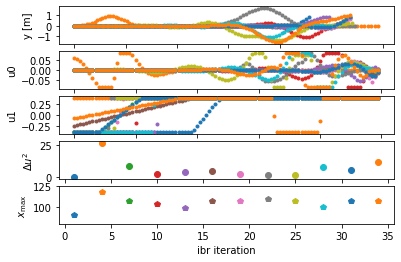

In [8]:
br2 = mpc.IterativeBestResponseMPC(x1_MPC, x2_MPC, amb_MPC )
br2.generate_optimization(N, min_dist, fd, T, x0_2, x0, x0_amb, 2, slack=True)
fig, ax = plt.subplots(5,1)
ax_t = ax[0]
ax_u0 = ax[1]
ax_u1 = ax[2]
ax_usum = ax[3]
ax_xmax = ax[4]
n_total_round = 12

all_amb = np.zeros((6,101, int(n_total_round)))
subdir_name = "20200220-163834_ibr_ego_finalcosts"
folder = "results/" + subdir_name + "/"

initial = True
for ibr_sub_it in range(1, 3*n_total_round + 1):
    if (ibr_sub_it % 3) == 0:
        response_car = "1"
    elif (ibr_sub_it % 3) == 1:
        response_car = "a"
    else:
        response_car = "2"
        
    if response_car == "a":
        ibr_prefix =  '%02d'%ibr_sub_it + "_" + response_car
            
        x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des = br2.load_state(folder + ibr_prefix)
        if initial:
            prev_u = uamb
            initial = False
        
        change_in_u = uamb - prev_u
        mag_change_in_u = (change_in_u**2).sum()
        
        ax_t.plot(xamb[0,:],xamb[1,:],'.')
        ax_u0.plot(uamb[0,:],'.')
        ax_u1.plot(uamb[1,:],'.')
        ax_usum.plot(ibr_sub_it, mag_change_in_u,'o')
        ax_xmax.plot(ibr_sub_it, xamb[0,-1],'p')
        prev_u = uamb
        
        all_amb[:,:,int(ibr_sub_it/3)] = xamb
        

ax_t.set_ylabel('y [m]')
ax_t.set_xlabel('x [m]')

ax_u0.set_ylabel('u0')
ax_u0.set_xlabel('t [100ms]')

ax_u1.set_ylabel('u1')
ax_u1.set_xlabel('t [100ms]')

ax_usum.set_ylabel(r'$\Delta u^2$')
ax_usum.set_xlabel('ibr iteration')

ax_xmax.set_ylabel(r'$x_{\max}$')
ax_xmax.set_xlabel('ibr iteration')
ax_xmax.set_ylim([80,125])

plt.show()

In [9]:
max_x = np.max(all_amb[0,:,:],axis=0)
print("Ego: Final %.02f Mean %.02f Max %.02f, Min %.02f"%(max_x[-1], np.mean(max_x), np.max(max_x), np.min(max_x)))
print(max_x)

Ego: Final 107.32 Mean 105.36 Max 118.26, Min 91.10
[ 91.1  118.26 107.04 103.33  99.07 107.09 107.11 109.21 107.83  99.98
 107.03 107.32]
